<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation

## Install libraries

Note: After installing the libraries for the first time restart the runtime for the new versions of the library to be loaded.

In [ ]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 2.8MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774878 sha256=e7514f1ca48722465229e75385335685c91a3dff32b37db125b8fc7eff69172c
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=ffc56829ac768d82a84e0508608b673b8938d9fb83bd8a6e73342dc2ffabc1ea
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 17.9MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119216 sha256=aa8b9

## Custom Functions

In [ ]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True,rmse=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=1

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,150,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    # Root mean squared error
    if rmse:
      from pysurvival.utils.display import compare_to_actual

      rmse_result = compare_to_actual(model, X_test, T_test, E_test,
                                  is_at_risk = False,  figure_size=(16, 6),
                                  metrics = ['rmse'])


    #return results
    results = pd.DataFrame({'c_index':[c_index],
                            'ibs':[ibs],
                            'mean_auc':[mean_auc],
                            'rmse':[rmse_result['root_mean_squared_error']]})
    return results

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Create Train, Test and Eval datasets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA
data_statistics = raw_data.describe()

## Remove negative time
raw_data = raw_data[raw_data['time']>=0]

for feature in ['products_created','admin_visits','tx','gmv_usd']:

  # Remove data with the quantiles method
  q1 = data_statistics[feature]['25%']
  q3 = data_statistics[feature]['75%']
  iqr = q3 - q1
  raw_data = raw_data[~((raw_data[feature] < (q1 - 1.5 * iqr)) | (raw_data[feature] > (q3 + 1.5 * iqr))) ]

  # Remove data with the std method
  raw_data = raw_data[raw_data[feature] <= (data_statistics[feature]['mean'] + 3 * data_statistics[feature]['std'])]
  
## Remove tx feature
raw_data.drop(['tx'], axis=1, inplace=True)

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Model Evaluation

### Train the model

In [ ]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd

## Build the model
model = RandomSurvivalForestModel(num_trees=100)
model.fit(X_train, T_train, E_train,seed=2020,
        max_features="sqrt", max_depth=5, min_node_size=5)

RandomSurvivalForestModel

### Feature Importance

In [ ]:
# Computing feature importance
feature_importance = model.variable_importance_table
feature_importance.head(10)

,feature,importance,pct_importance
0,max_segment_C,12.403607,0.162932
1,seller_probability,8.193331,0.107627
2,max_segment_B,7.390267,0.097078
3,country_C,4.721852,0.062026
4,max_segment_D,4.535858,0.059583
5,source_D,4.499059,0.059099
6,country_A,3.770486,0.049529
7,source_E,3.722385,0.048897
8,admin_visits,3.610283,0.047424
9,gmv_usd,3.399417,0.044654


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


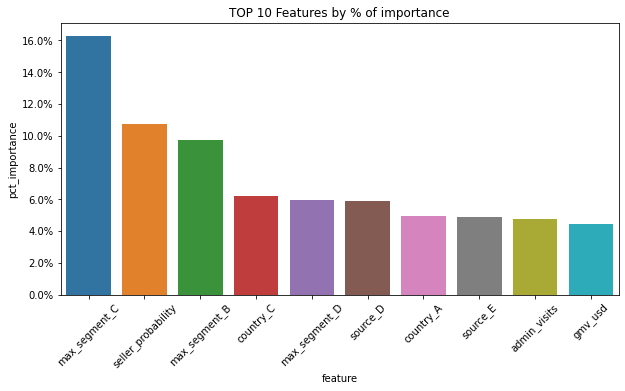

In [ ]:
# feature_importance.plot.bar(x='feature', y='pct_importance', rot=0);

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(10,5))

# Multiply 100 to make it a percentage.
feature_importance['pct_importance'] = feature_importance['pct_importance']*100

ax = sns.barplot(x='feature', y='pct_importance', data=feature_importance[:10])
ax.set_title('TOP 10 Features by % of importance')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

#### max_segment_C


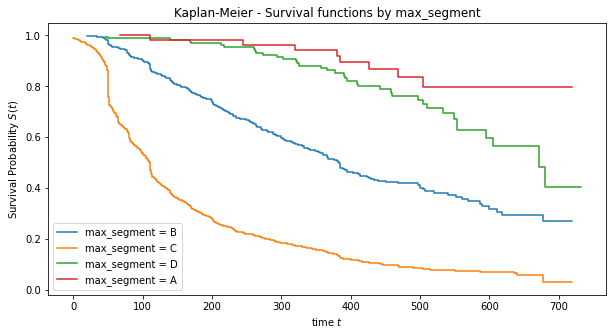

In [ ]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

plt.figure(figsize=(10,5))

raw_data['event'] = raw_data['event'].astype(bool)

for max_segment in ['B', 'C', 'D', 'A']:
    mask_segment = raw_data['max_segment'] == max_segment
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        raw_data['event'][mask_segment],
        raw_data['time'][mask_segment])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="max_segment = %s" % max_segment)

plt.ylabel("Survival Probability $S(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.title('Kaplan-Meier - Survival functions by max_segment');

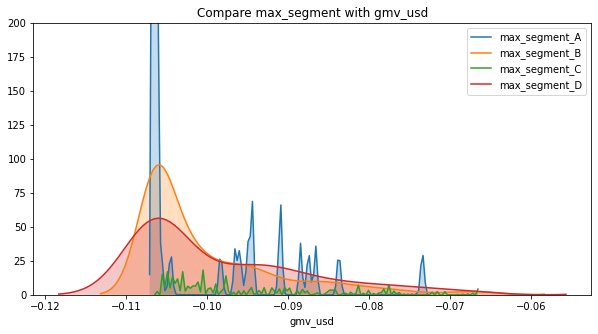

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

ax = sns.kdeplot(raw_data.loc[raw_data['max_segment'] == 'A','gmv_usd'], shade=True,label='max_segment_A')
ax = sns.kdeplot(raw_data.loc[raw_data['max_segment'] == 'B','gmv_usd'], shade=True,label='max_segment_B')
ax = sns.kdeplot(raw_data.loc[raw_data['max_segment'] == 'C','gmv_usd'], shade=True,label='max_segment_C')
ax = sns.kdeplot(raw_data.loc[raw_data['max_segment'] == 'D','gmv_usd'], shade=True,label='max_segment_D')

# control x and y limits
ax.set_ylim(0, 200)
ax.set_xlabel('gmv_usd')
ax.set_title("Compare max_segment with gmv_usd");




In [ ]:
from scipy import stats

print('max_segment_C gmv_usd mean:{:3.2f} and std:{:4.3f}'.format(raw_data.loc[raw_data['max_segment'] == 'C','gmv_usd'].mean(),
                                                                  raw_data.loc[raw_data['max_segment'] == 'C','gmv_usd'].std()))

for max_segment in ['A','B','D']:
  print('max_segment_{} gmv_usd mean:{:3.2f} and std:{:4.3f}'.format(max_segment,
                                                                     raw_data.loc[raw_data['max_segment'] == 'C','gmv_usd'].mean(),
                                                                     raw_data.loc[raw_data['max_segment'] == 'C','gmv_usd'].std()))
  print(stats.ttest_ind(raw_data.loc[raw_data['max_segment'] == 'C','gmv_usd'],
                  raw_data.loc[raw_data['max_segment'] == max_segment,'gmv_usd'], 
                  equal_var = False))

max_segment_C gmv_usd mean:-0.11 and std:0.004
max_segment_A gmv_usd mean:-0.11 and std:0.004
Ttest_indResult(statistic=-2.716609385619756, pvalue=0.008669043314072665)
max_segment_B gmv_usd mean:-0.11 and std:0.004
Ttest_indResult(statistic=-14.265345848940786, pvalue=8.438549876651131e-41)
max_segment_D gmv_usd mean:-0.11 and std:0.004
Ttest_indResult(statistic=-8.615949324606008, pvalue=4.295575975693901e-15)


In [ ]:
raw_data.loc[raw_data['max_segment'] == 'C','gmv_usd'].describe()

count    1645.000000
mean       -0.105479
std         0.004114
min        -0.106463
25%        -0.106463
50%        -0.106463
75%        -0.106463
max        -0.066519
Name: gmv_usd, dtype: float64

#### seller_probability

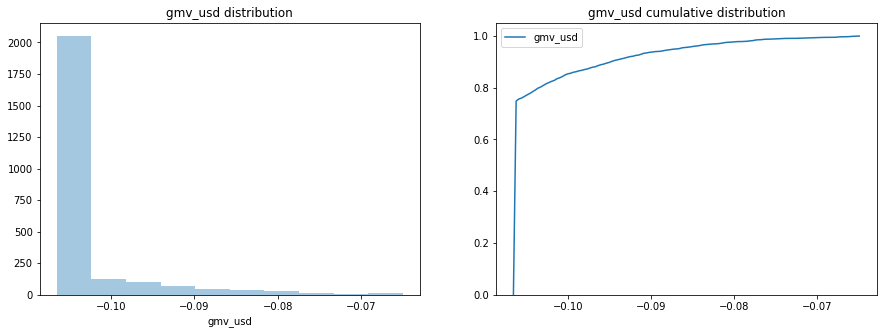

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.title('gmv_usd distribution')

plt.subplot(1,2,1)
sns.distplot(raw_data['gmv_usd'], kde=False, bins=10)
plt.title('gmv_usd distribution')

plt.subplot(1,2,2)
sns.kdeplot(raw_data['gmv_usd'], cumulative=True)
plt.title('gmv_usd cumulative distribution');

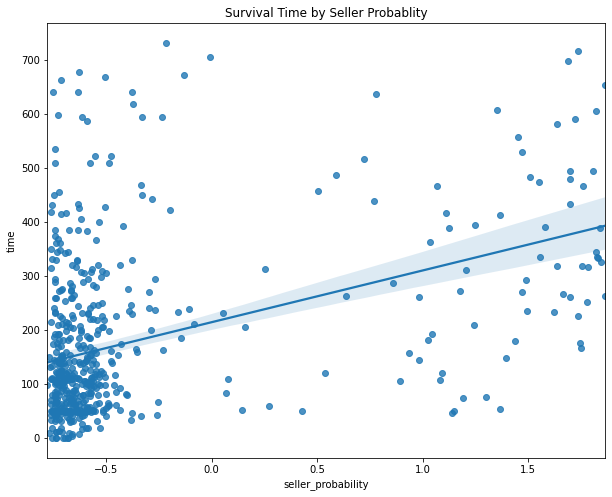

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.regplot(x=X_train['seller_probability'], y=T_train)

plt.title('Survival Time by Seller Probablity');

#### country

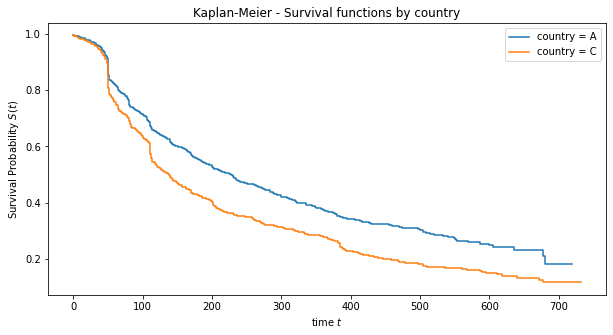

In [ ]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

plt.figure(figsize=(10,5))

raw_data['event'] = raw_data['event'].astype(bool)

for country in ['A','C']:
    mask_segment = raw_data['country'] == country
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        raw_data['event'][mask_segment],
        raw_data['time'][mask_segment])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="country = %s" % country)

plt.ylabel("Survival Probability $S(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.title('Kaplan-Meier - Survival functions by country');

### Evaluate the model on the 3 key metrics

c-index: 0.7604


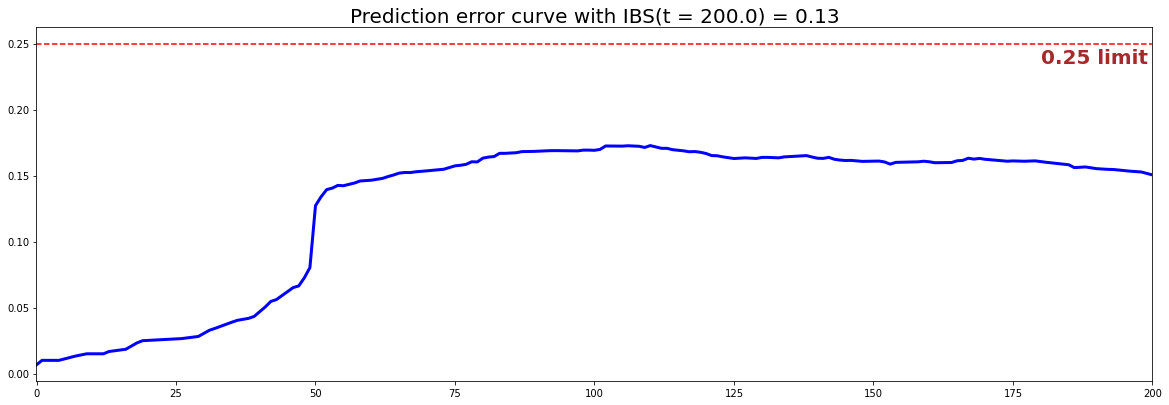

IBS: 0.1286
AUC: 0.8483


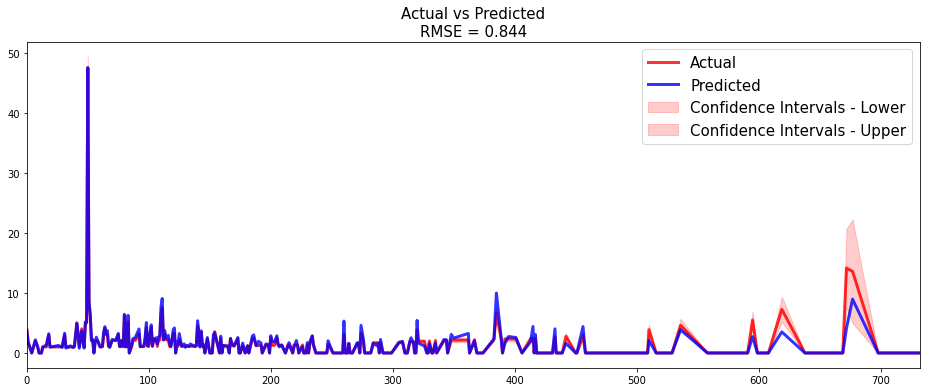

c-index: 0.7041


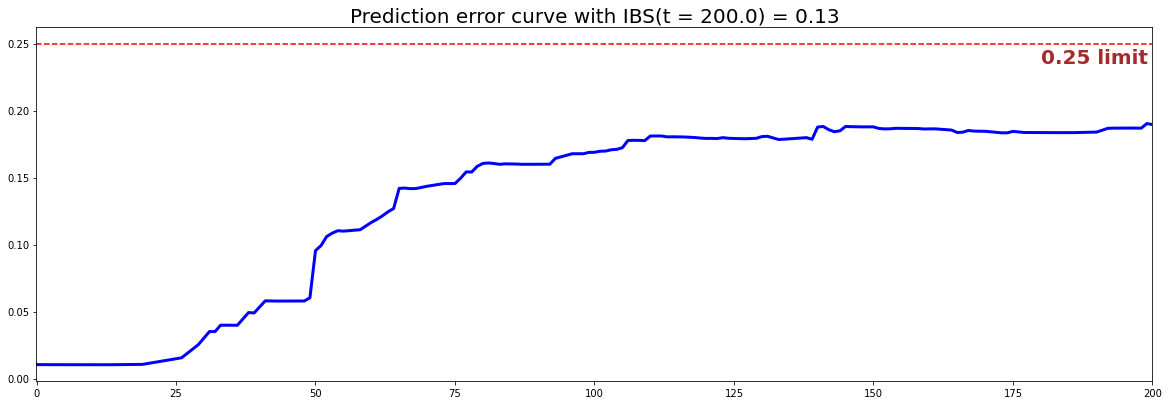

IBS: 0.1341
AUC: 0.7813


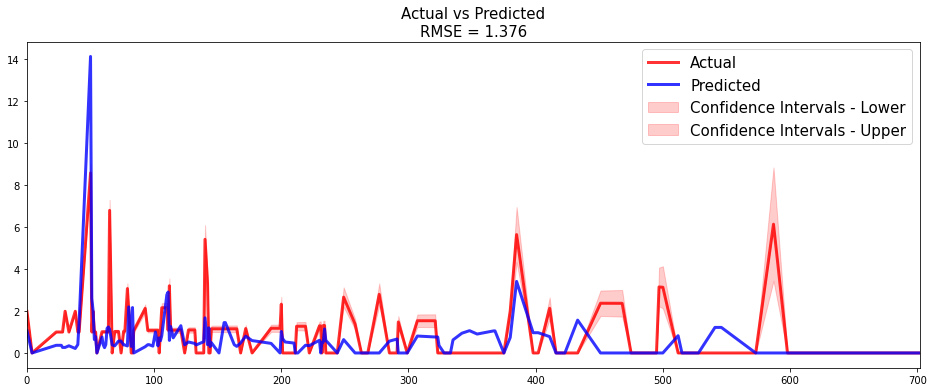

c-index: 0.6919


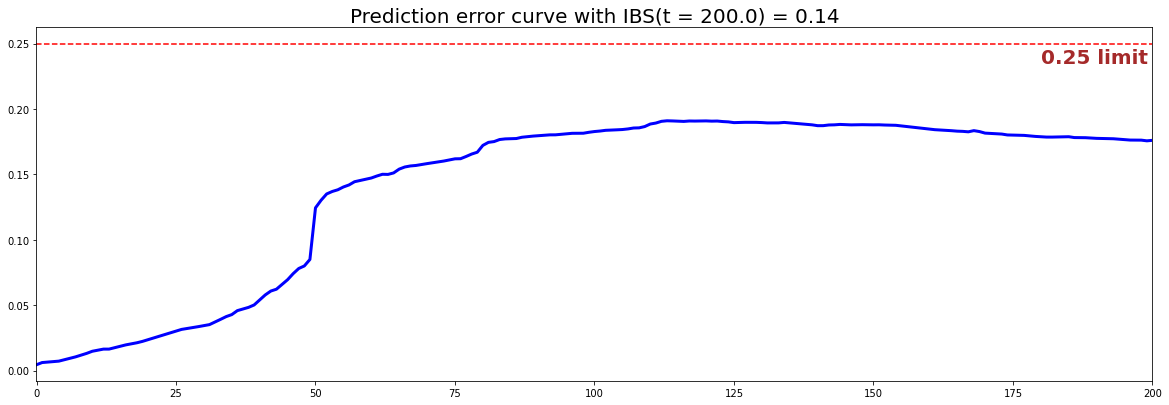

IBS: 0.1417
AUC: 0.7718


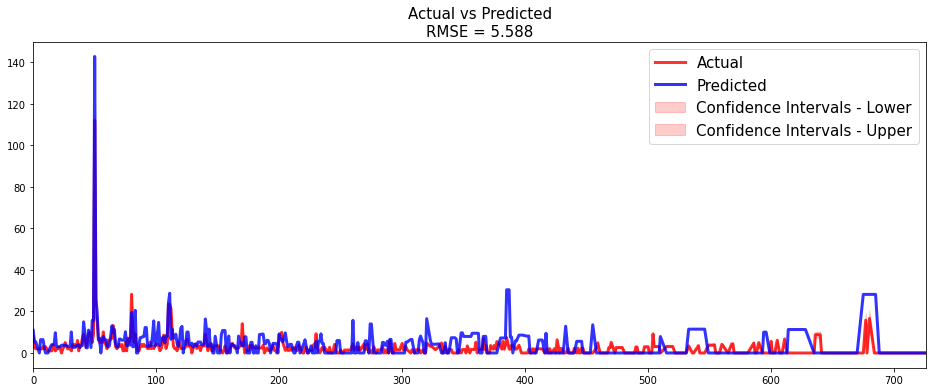

In [ ]:
import pandas as pd

results = pd.DataFrame()

# Train data
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_train,T_train,E_train)
tmp_results['data'] = 'train'
results = pd.concat([results,tmp_results])

# Test data
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['data'] = 'test'
results = pd.concat([results,tmp_results])

# Evaluation data
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_eval,T_eval,E_eval)
tmp_results['data'] = 'eval'
results = pd.concat([results,tmp_results])

In [ ]:
# Show results
results.round(4)

,c_index,ibs,mean_auc,rmse,data
0,0.7604,0.1286,0.8483,0.8440,train
0,0.7041,0.1341,0.7813,1.3760,test
0,0.6919,0.1417,0.7718,5.5885,eval
